In [2]:
# I like to start by checking if the GPU was initiated succesfully,
# and by seeing the tensroflow and python versions being used
# by the notebook.

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf, sys
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

print('tensorflow version: %s' % tf.__version__)
print('python version: %s' % sys.version)
print('python executable location: %s' % sys.executable)

# --------------------------------------------------------------
# --------------------------------------------------------------

%matplotlib inline
%load_ext autoreload
%autoreload 2

from helpers import *
import os, sys, tarfile, time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.ticker import MaxNLocator
import pickle

params = {'legend.fontsize': 'x-large',
          'font.size'      : 11,
          'figure.figsize' : (17, 6),
          'axes.labelsize' : 'x-large',
          'axes.titlesize' : 'x-large',
          'axes.grid'      : 'on',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}

pylab.rcParams.update(params)



[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3009877724913181669
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 384172032
locality {
  bus_id: 1
}
incarnation: 7399951434144391997
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0"
]
tensorflow version: 1.0.0
python version: 3.6.1 |Continuum Analytics, Inc.| (default, May 11 2017, 13:09:58) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
python executable location: /home/aind2/anaconda3/envs/aind-dog/bin/python
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Reading train_*.npy , cv_*.npy , test_*.npy and and u_mean.pkl files....
n_movies 27278
Runtime: 0 min 10 sec


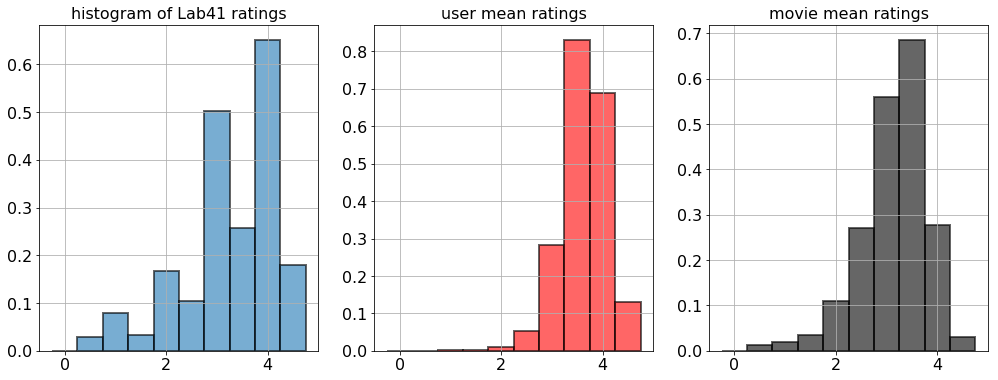

In [3]:
# Read Lab41 dataset into:
#                          train_R, cv_R, test_R
#                          train_R_indices, cv_R_indices, test_R_indices
start = time.time()
#...................................................
train_R_indices, train_R, cv_R_indices, \
        cv_R, test_R_indices, test_R, \
        n_users, n_movies, u_mean_dict, v_mean_dict = read_and_split_data()

ax = plt.subplot(131)
ax.hist(np.concatenate((train_R, cv_R, test_R)), bins=np.arange(-.25, 5.25, 0.5), alpha=.6, \
         edgecolor='black', linewidth=2, normed=True);
ax.set_title('histogram of Lab41 ratings');
# plt.gcf().savefig('fig1.png')
#...................................................

ax = plt.subplot(132)
ax.hist((list(u_mean_dict.values())), bins=np.arange(-.25, 5.25, 0.5), alpha=.6, \
        color='red', edgecolor='black', linewidth=2, normed=True);
ax.set_title('user mean ratings');
# plt.gcf().savefig('fig2.png')

ax = plt.subplot(133)
ax.hist((list(v_mean_dict.values())), bins=np.arange(-.25, 5.25, 0.5), alpha=.6, \
        color='black', edgecolor='black', linewidth=2, normed=True);
ax.set_title('movie mean ratings');
# plt.gcf().savefig('fig3.png')
print_runtime(start)


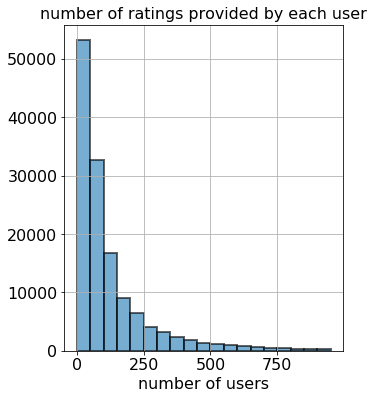

In [4]:
ind = np.concatenate((train_R_indices, cv_R_indices, test_R_indices), axis=0) 
import pandas as pd
df = pd.DataFrame(ind, columns=['i','j'])
gr = df.groupby('i')
# ----------------------
ax = plt.subplot(131)
ax.hist(gr.size(), bins=np.arange(0,1000,50), alpha=.6, \
        edgecolor='black', linewidth=2);
ax.set_title('number of ratings provided by each user');
ax.set_xlabel('number of users')
plt.gcf().savefig('fig4.png')

In [6]:
start = time.time()

train_u_mean, train_v_mean = get_train_u_mean(train_R_indices, u_mean_dict, v_mean_dict)

print_runtime(start)

Runtime: 0 min 16 sec



NUM_EPOCHS: 10
LAMBDA: 0.001
k: 10
lr: 0.01
n_batches: 781
BATCH_SIZE: 16384
New epoch: 1 ******************************
batch_no: 781, _loss estimate: 0.8738, t= 42.83 sec
mae_train: 0.6172, **mae_cv: 0.6368**, mae_test: 0.6373,  mean(preds): 3.5155
New epoch: 2 ******************************
batch_no: 781, _loss estimate: 0.8095, t= 38.25 sec
mae_train: 0.5859, **mae_cv: 0.6205**, mae_test: 0.6210,  mean(preds): 3.5376
New epoch: 3 ******************************
batch_no: 781, _loss estimate: 0.7832, t= 38.28 sec
mae_train: 0.5699, **mae_cv: 0.6154**, mae_test: 0.6159,  mean(preds): 3.5378
New epoch: 4 ******************************
batch_no: 781, _loss estimate: 0.7673, t= 38.18 sec
mae_train: 0.5602, **mae_cv: 0.6131**, mae_test: 0.6135,  mean(preds): 3.5385
New epoch: 5 ******************************
batch_no: 781, _loss estimate: 0.7570, t= 37.88 sec
mae_train: 0.5541, **mae_cv: 0.6123**, mae_test: 0.6126,  mean(preds): 3.5375
New epoch: 6 ******************************
batch_no

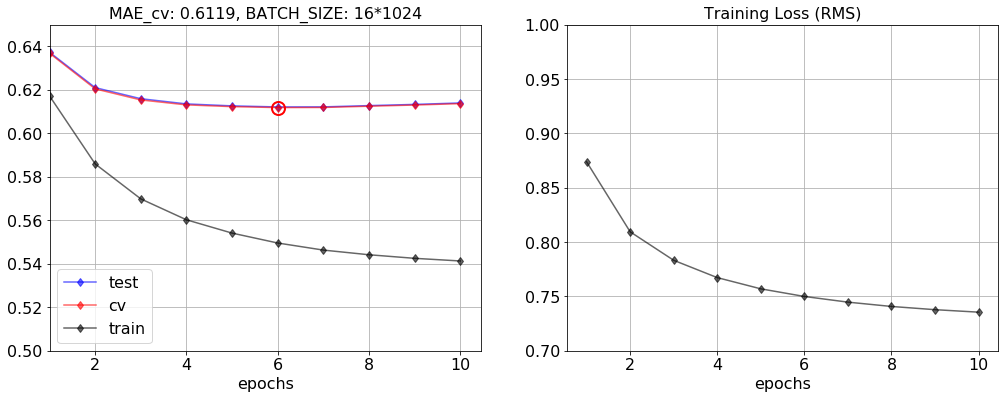

In [20]:
# hyperparameters
# BATCH_SIZE = 1024*16
BATCH_SIZE_arr = [1024*16]
# LAMBDA_ARR = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.00125]
LAMBDA = 0.001
k = 10 # an important hyperparameter.
lr = 0.01
NUM_EPOCHS = 10
if 'out.txt' in os.listdir(): 
    os.remove('out.txt')
    
for BATCH_SIZE in BATCH_SIZE_arr:
    #.............................................. 
    train, loss, reg, R_indices, R, U, V, R_pred, X_UV, u_mean, v_mean = \
                            construct_graph(LAMBDA, k, lr, BATCH_SIZE, n_users, n_movies)
    #.............................................. 

    start = time.time()
    mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr, mean_preds, n_batches, preds, \
                   _U, _V, _X_UV = \
                         train_the_model(R_indices, R, train_R_indices, train_R, BATCH_SIZE, 
                   NUM_EPOCHS, LAMBDA, k, lr, 
                   train, loss, reg, U, V, R_pred,
                   cv_R, cv_R_indices, test_R, test_R_indices,
                   X_UV,
                   train_u_mean, train_v_mean, u_mean, v_mean)
    #.............................................. 
    # plotting....
    ax1, ax2 = plotter(mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr, BATCH_SIZE)

#.............................................. 
print_runtime(start)

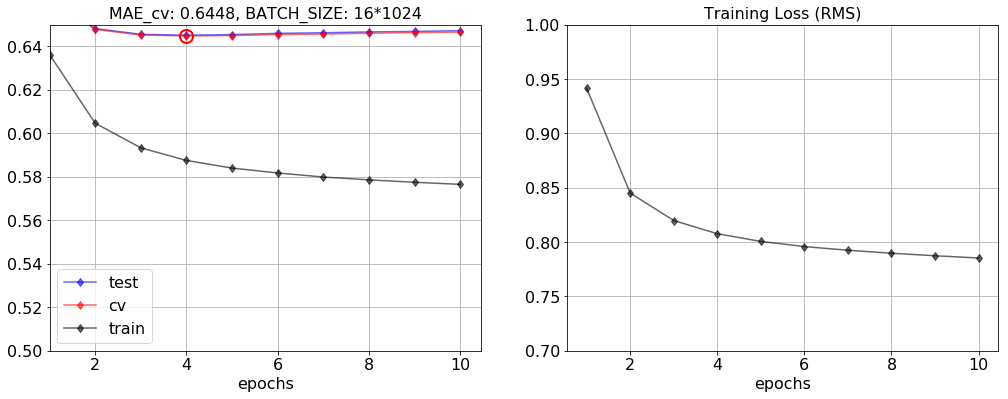

In [12]:
ax1, ax2 = plotter(mae_train_arr, mae_cv_arr, mae_test_arr, loss_arr, BATCH_SIZE)